In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import os
import pandas as pd
import re
from nltk import ne_chunk, pos_tag, word_tokenize
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation 
%pylab inline
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
import pickle
tf.__version__

Populating the interactive namespace from numpy and matplotlib


'2.5.0'

In [ ]:
# loading image array
file1 = open("image_lists2.pkl", "rb")
image_lists = pickle.load(file1)
file1.close()

# loading word character 
file2 = open("char.pkl", "rb")
char = pickle.load(file2)
file2.close()

In [7]:
#function to extract feature extaction for given image
vgg16_model = tf.keras.applications.resnet.ResNet101(weights='imagenet',include_top=False,input_shape=([96, 96, 3]))

def restnet101():
  model = tf.keras.Sequential()

  model.add(vgg16_model)
  model.add(Conv2D(1024, (1, 1), activation = 'relu', name='block6_conv1'))

  model.add(UpSampling2D((2,2), interpolation = 'bilinear'))

  model.add(keras.layers.Reshape([36, 1024]))
  model.add(tf.keras.layers.Dense(256,activation='relu'))

  return model


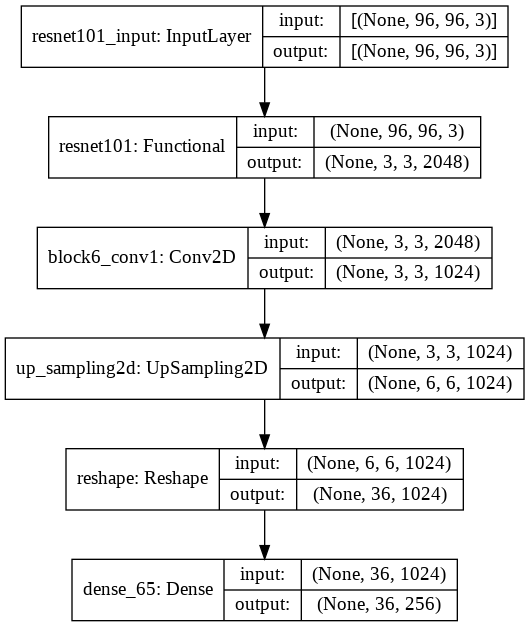

In [18]:
generator = restnet101()

keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

In [ ]:
image_list = np.array([i[0] for i in lists]) # character tokenizing 

t = Tokenizer(filters='|', char_level=True, oov_token=True) 
t.fit_on_texts(v)
values = list((t.texts_to_sequences(v)))

for i in range(len(values)):
  values[i] = [38] + values[i] + [39]  #adding '39' as 'END' index to each list

sen_list = sequence.pad_sequences(values, maxlen=24,padding='post',truncating='post')

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((image_list, sen_list))
dataset

<TensorSliceDataset shapes: ((96, 96, 3), (24,)), types: (tf.float32, tf.int32)>

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 10
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE))



train_batches = make_batches(dataset)

(1, 2048, 512)


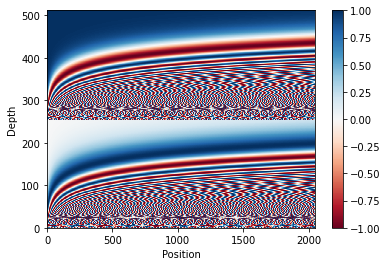

In [20]:
#source :- https://www.tensorflow.org/text/tutorials/transformer
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)  



def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32) 


n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [21]:
#source :- https://www.tensorflow.org/text/tutorials/transformer
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)  


def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])



class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2



class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2 


from tensorflow.keras.layers import Input, Add
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)


class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights



class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):
    
    generated_images = generator(inp, training=True)

    enc_output = self.tokenizer(generated_images, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights
    #return enc_output  

Text(0.5, 0, 'Train Step')

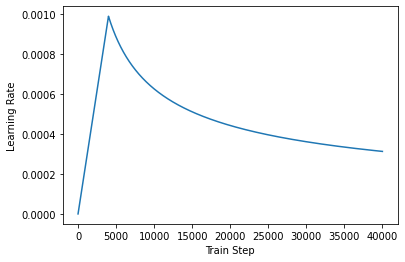

In [22]:
transformer = Transformer(
    num_layers=4, d_model=256, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=40,
    pe_input=10000, pe_target=6000)

num_layers = 4      # number of layer used in model
d_model = 256       # size of embedding dimension
dff = 2048          # size of feed for network
num_heads = 8       #size of multi heading 
dropout_rate = 0.1  #dropout rate

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)
optimizer =  tf.keras.optimizers.RMSprop(learning_rate=0.01,rho=0.9,momentum=0.0,epsilon=1e-07)


temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
  return loss_


def accuracy_function(real, pred):
  real = tf.cast(real, dtype=tf.int64)
  pred = tf.cast(pred, dtype=tf.int64)
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

def create_masks(tar):

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return combined_mask

In [24]:
trans_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)


checkpoint_path = "./checkpointzs/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           trans_optimizer=trans_optimizer)


ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [27]:
EPOCHS = 400

@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  combined_mask = create_masks(tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 None,
                                 combined_mask,
                                 None)
    loss = loss_function(tar_real, predictions)
  gradients_trans = tape.gradient(loss, transformer.trainable_variables)
  trans_optimizer.apply_gradients(zip(gradients_trans, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [22]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> image , tar -> character string
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Loss 0.9811 Accuracy 0.1362
Time taken for 1 epoch: 68.53 secs

Epoch 2 Loss 0.6704 Accuracy 0.2428
Time taken for 1 epoch: 25.18 secs

Epoch 3 Loss 0.6426 Accuracy 0.2739
Time taken for 1 epoch: 25.55 secs

Epoch 4 Loss 0.6275 Accuracy 0.2879
Time taken for 1 epoch: 24.80 secs

Saving checkpoint for epoch 5 at ./checkpointz/train/ckpt-1
Epoch 5 Loss 0.6267 Accuracy 0.2857
Time taken for 1 epoch: 25.40 secs

Epoch 6 Loss 0.6252 Accuracy 0.2858
Time taken for 1 epoch: 24.82 secs

Epoch 7 Loss 0.6386 Accuracy 0.2725
Time taken for 1 epoch: 24.43 secs

Epoch 8 Loss 0.6497 Accuracy 0.2590
Time taken for 1 epoch: 24.50 secs

Epoch 9 Loss 0.6594 Accuracy 0.2478
Time taken for 1 epoch: 24.48 secs

Saving checkpoint for epoch 10 at ./checkpointz/train/ckpt-2
Epoch 10 Loss 0.6590 Accuracy 0.2512
Time taken for 1 epoch: 25.06 secs

Epoch 11 Loss 0.6705 Accuracy 0.2348
Time taken for 1 epoch: 24.77 secs

Epoch 12 Loss 0.6806 Accuracy 0.2272
Time taken for 1 epoch: 41.25 secs

Epoch 13 Los

In [17]:
#function to evaluate performance of model
def evaluate(image, max_length=24):
  #input image
  encoder_input = image

  li = [36] #passing 'Start' index 
  output = tf.convert_to_tensor([li])

  for i in range(max_length):

    output = tf.convert_to_tensor([li]) #converting into tensor
    
    #model predicting word character and atttention weight
    predictions, attention_weights = transformer(encoder_input,output,False,None,None,None)
    
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1) #getting index from the list which has highest logit score

    predicted_id = predicted_id.numpy()
    li.append(predicted_id[0][0]) #appending the index to list
    
    #check if the predicted index is equal to index of 'End'
    if predicted_id[0][0] == 39:
      break


  return li, attention_weights

In [24]:
# pedicting the corresponding word character for given image
image  = lists[100]
predict , attention_weights = evaluate(image, max_length=24)

In [23]:
k = t.word_index
word_dict = {}
for i , j in k.items():
  j = str(j)
  word_dict[j] = i

# visualizing the image and its corresponding groundtruth word and predicted word
def visualize(image , groundtruth , predicted):

  #print image
  plt.figure(figsize=(2, 2))
  plt.title('Image')
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
  plt.axis('off') 

  #print Groundtruth word 
  string1 = [ word_dict[str(i)]  for i in groundtruth[1:-1]]
  s = ""
  s = s.join(string1)
  print(f'The groundtruth word is : {s}')

  #print predicted word 
  string2 = [ word_dict[str(i)]  for i in predicted[1:-1]]
  s = ""
  s = s.join(string2)
  print(f'The predicted word is : {s}')

In [24]:
#print Groundtruth word 
string2 = [ word_dict[str(i)]  for i in predicted[1:-1]]
s = ""
s = s.join(string1)
print(f'The groundtruth word is : {s}')

The groundtruth word is : nilhtid


The groundtruth word is : night
The predicted word is : nilhtid


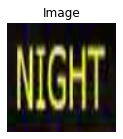

In [25]:
# pedicting the corresponding word character for given image
image = lists[100]
actual_word = values[100]
predicted , attention_weights = evaluate(image, max_length=24)
visualize(image ,actual_word , predicted)

In [26]:
def plot_attention_head(attention ,h ,  string2):
  fig = plt.figure(figsize=(20,20))
  ax = fig.add_subplot(1, 1, 1)
  i = h +1
  head = 'Head ' + str(i)
  plt.title(head)
  ax.matshow(attention[h][0:], cmap='viridis')
  fontdict = {'fontsize': 50}
  ax.set_yticklabels([''] + string2, fontdict=fontdict, rotation=90)

def plot(attention_weights,string2):
  attention = attention_weights['decoder_layer1_block2']
  attention = attention[0]
  fig = plt.figure(figsize=(16, 8))
  for h in range(8):
    plot_attention_head(attention ,h , string2)

The Y-axis is the feature map dimension of image.


<Figure size 1152x576 with 0 Axes>

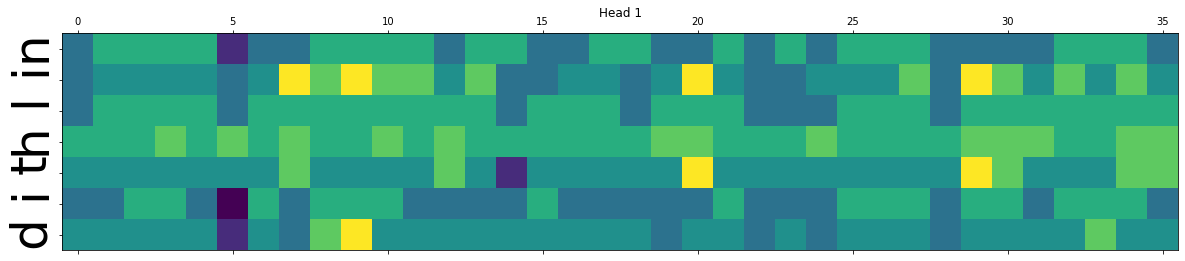

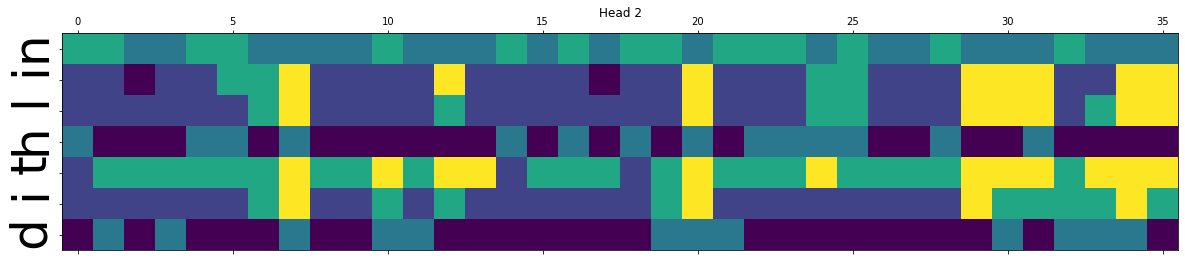

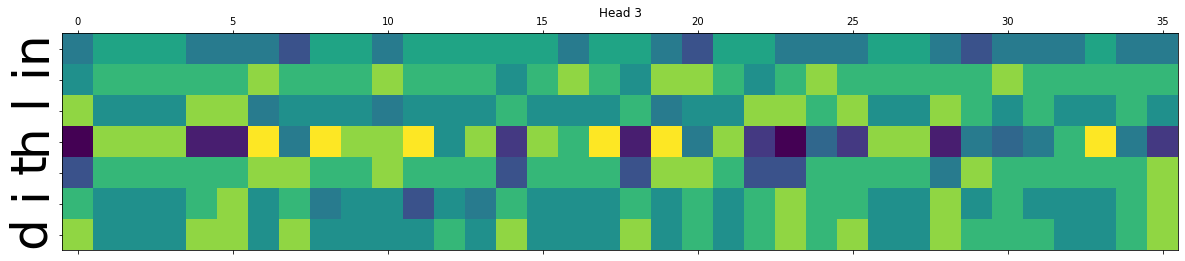

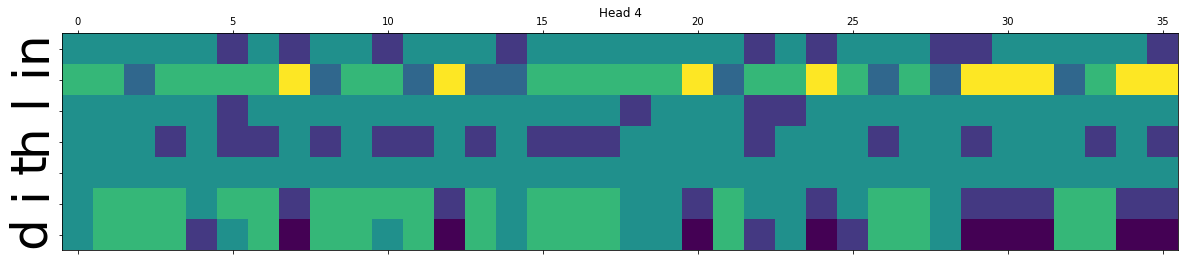

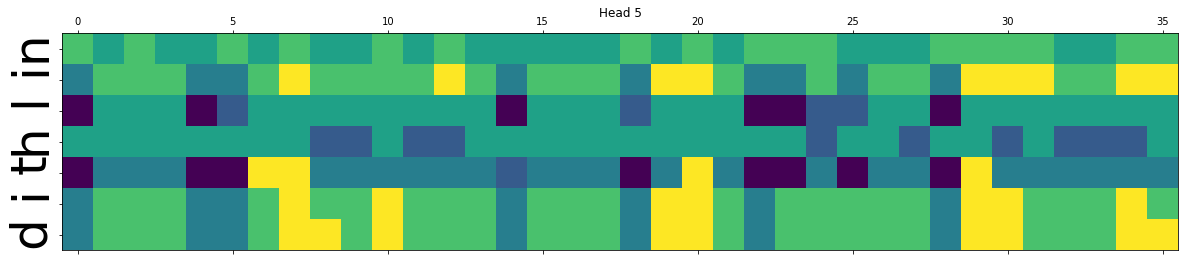

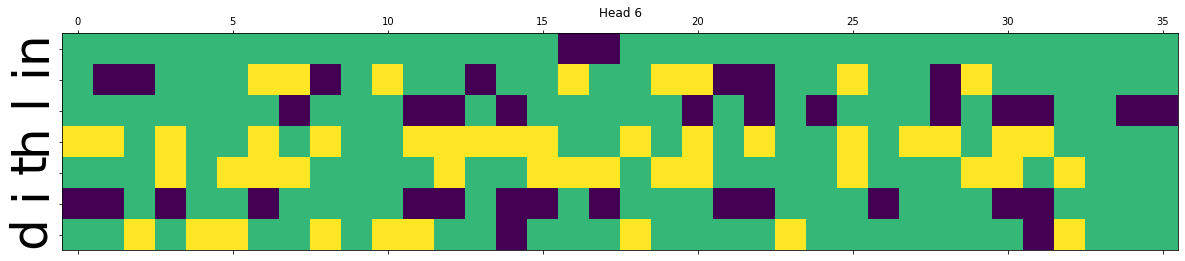

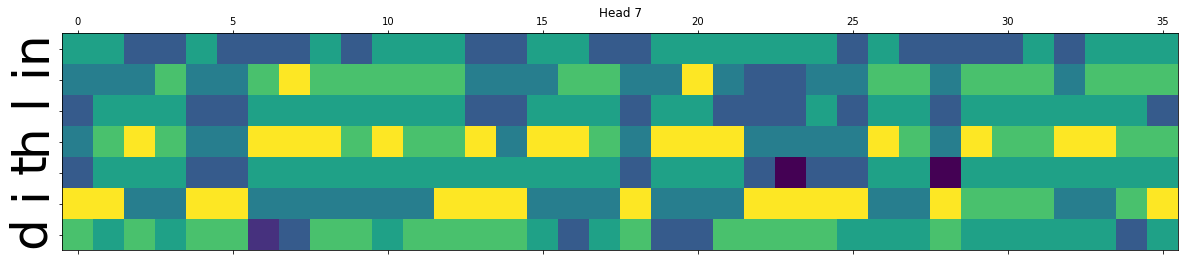

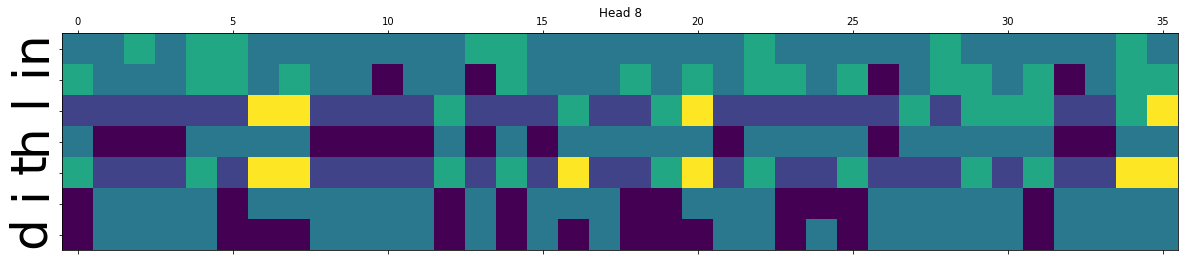

In [27]:
print(f'The Y-axis is the feature map dimension of image.')
plot(attention_weights,string2)